In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import loompy
import matplotlib.pyplot as plt
import scipy.optimize
import velocyto as vcy
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [ ]:
!mkdir data

In [36]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

('data/hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7f8e2c2f9588>)

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

In [3]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

# Load raw data

In [4]:
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")

In [5]:
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.Vega20b(np.linspace(0., 1, 20))[::2], plt.cm.Vega20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluter_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

# Load tsne and clusters from pagoda

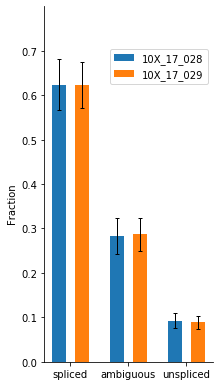

In [6]:
vlm.plot_fractions()

# Velocity Analysis

In [7]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [8]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

2017-10-18 09:26:27,284 - DEBUG - Filtering by detection level


2017-10-18 09:26:29,310 - DEBUG - Filtering by cv vs mean


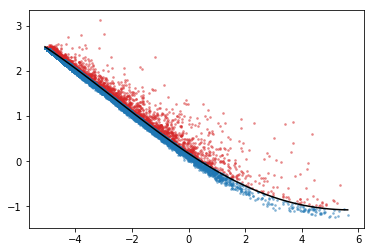

In [9]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [10]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

2017-10-18 09:26:29,453 - INFO - Cluster: 0 (187 cells)
2017-10-18 09:26:29,456 - INFO - Cluster: 1 (332 cells)
2017-10-18 09:26:29,460 - INFO - Cluster: 2 (94 cells)
2017-10-18 09:26:29,462 - INFO - Cluster: 3 (249 cells)
2017-10-18 09:26:29,465 - INFO - Cluster: 4 (347 cells)
2017-10-18 09:26:29,470 - INFO - Cluster: 5 (243 cells)
2017-10-18 09:26:29,473 - INFO - Cluster: 6 (268 cells)
2017-10-18 09:26:29,476 - DEBUG - Filtering by cluster expression
2017-10-18 09:26:29,477 - DEBUG - Filtering by detection level


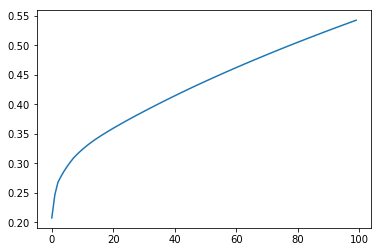

In [11]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]

In [12]:
from sklearn.neighbors import NearestNeighbors
import igraph
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [13]:
from numpy_groupies import aggregate

In [14]:
pc_obj = principal_curve(vlm.pcs[:,:4], False)
labels = np.argsort(aggregate(labels, pc_obj.arclength, func="mean"))[labels]

In [15]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.Vega20b(np.linspace(0., 1, 20))[::2], plt.cm.Vega20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluter_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [16]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))


2017-10-18 09:26:33,487 - DEBUG - First search the 1719 nearest neighbours for 1720
2017-10-18 09:26:34,143 - DEBUG - Using the initialization network to find a 550-NN graph with maximum connectivity of 1719
2017-10-18 09:26:34,175 - DEBUG - Returning sparse matrix


In [17]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [18]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [19]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [20]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="sqrt", psc=0.1,
                             n_neighbors=300, knn_random=True, sampled_fraction=1)

2017-10-18 09:26:40,361 - DEBUG - Calculate KNN in the embedding space
2017-10-18 09:26:41,244 - DEBUG - Correlation Calculation 'knn_random'
2017-10-18 09:26:42,909 - DEBUG - Done Correlation Calculation


In [21]:
vlm.calculate_embedding_shift(sigma_corr = 0.2)

2017-10-18 09:26:42,917 - DEBUG - Calculate transition probability


In [22]:
vlm.calculate_grid_arrows(smooth=0.7, steps=(25, 25), n_neighbors=300)

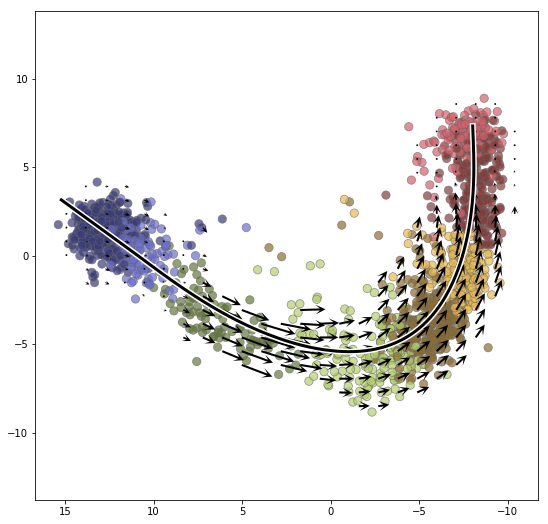

In [23]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":False}, min_mass=2., angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.25)
#plt.savefig("/data/proj/velocity/Figure3_tsne_arrows_raster.pdf")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("on")
plt.axis("equal");

# Plot different dynamics

Filter genes that peak at the different timepoints removing the ones that show low correlation between velocity and expression

In [24]:
segments = np.linspace(0, np.max(pc_obj.arclength),10)
fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-1):
    fragments[(pc_obj.arclength > segments[i]) & (pc_obj.arclength <= segments[i+1])] = i
    
medial_fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-2):
    medial_fragments[(pc_obj.arclength > segments[i:i+2].mean()) & (pc_obj.arclength < segments[i+1:i+3].mean())] = i
    
s = aggregate(fragments[fragments>=0], vlm.Sx_sz[:, fragments>=0], func="mean", axis=1)
u = aggregate(fragments[fragments>=0], vlm.Ux_sz[:, fragments>=0], func="mean", axis=1)
v = aggregate(medial_fragments[medial_fragments>=0], vlm.Sx_sz_t[:, medial_fragments>=0] - vlm.Sx_sz[:, medial_fragments>=0], func="mean", axis=1)

In [25]:
# Enrichment score by pseutotime
n_cells = vlm.cluster_ix.shape[0]

# Number of cells per cluster
sizes = np.bincount(vlm.cluster_ix)
# Number of nonzero values per cluster
nnz = aggregate(vlm.cluster_ix, (vlm.Sx_sz>0).astype(float), func="sum", axis=1)
# Mean value per cluster
means = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
# Non-zeros and means over all cells
nnz_overall, means_overall = (vlm.Sx_sz>0).sum(1), vlm.Sx_sz.mean(1)
# Scale by number of cells
f_nnz = nnz / sizes
f_nnz_overall = nnz_overall / n_cells

# Means and fraction non-zero values in other clusters (per cluster)
means_other = ((means_overall * n_cells)[None].T - (means * sizes)) / (n_cells - sizes)
f_nnz_other = ((f_nnz_overall * n_cells)[None].T - (f_nnz * sizes)) / (n_cells - sizes)

enrichment = (f_nnz + 0.1) / (f_nnz_overall[None].T + 0.1) * (means + 0.01) / (means_overall[None].T + 0.01)

In [26]:
#List of top eneriched genes
list_enriched = []
score_enriched = []
for i in range(enrichment.shape[1]):
    score_enriched.append(enrichment[:,i][np.argsort(enrichment[:,i])[::-1]][:350])
    list_enriched.append(vlm.ra["Gene"][np.argsort(enrichment[:,i])[::-1]][:350])

In [29]:
def clean_duplicates(list_enriched, score_enriched):
    for i in range(len(list_enriched)):
        current_ = list_enriched[i]
        for j in range(len(current_)):
            gj = current_[j]
            for n in range(len(list_enriched[i+1:])):
                if gj in list_enriched[n+i+1] and gj != "":
                    if score_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] > score_enriched[i][j]:
                        list_enriched[i][j] = ""
                    else:
                        list_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] = ""
    for i in range(enrichment.shape[1]):
        list_enriched[i] = list_enriched[i][list_enriched[i] != ""]
    return list_enriched

def paired_correlations(X, Y):
    Xm = X - X.mean(0)
    Ym = Y - Y.mean(0)
    return (Xm * Ym).sum(0) / (np.linalg.norm(Xm,2,0) * np.linalg.norm(Ym,2,0))

In [30]:
Cc = paired_correlations((s[:,1:] - s[:,:-1]).T, v.T)

In [31]:
for i in range(enrichment.shape[1]):
    selection_bool = np.in1d(list_enriched[i], vlm.ra["Gene"][Cc>0.55])
    score_enriched[i] = score_enriched[i][selection_bool][:120]
    list_enriched[i] = list_enriched[i][selection_bool][:120]

In [32]:
list_enriched = clean_duplicates(list_enriched, score_enriched)

selected_genes_n = int(np.mean([len(list_enriched[i]) for i in range(len(list_enriched))]))
for i in range(enrichment.shape[1]):
    list_enriched[i] = list_enriched[i][:selected_genes_n]
list_enriched_flat = np.hstack(list_enriched)

list_enriched_flat_new = []
for i in list_enriched_flat:
    if i not in list_enriched_flat_new:
        list_enriched_flat_new.append(i)
list_enriched_flat= np.array(list_enriched_flat_new)

In [33]:
s = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
u = aggregate(vlm.cluster_ix, vlm.Ux_sz, func="mean", axis=1)

ix_filter = np.where(np.in1d(vlm.ra["Gene"], list_enriched_flat))[0]
gene_filtered = vlm.ra["Gene"][ix_filter]

Ssort = s[ix_filter,:] / s[ix_filter,:].sum(1)[:,None]
Usort = u[ix_filter,:] / u[ix_filter,:].sum(1)[:,None]
ix1 = np.argsort(Usort.argmax(1), kind='mergesort')
ix2 = np.argsort(Ssort[ix1, :].argmax(1), kind='mergesort')
ixa2b = ix1[ix2]

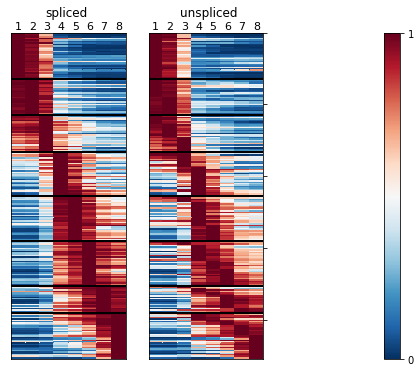

In [34]:
plt.figure(None, (7, 6))
plt.subplot(131)
plt.text(0.3,1.05,"spliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop='on', labelbottom='off', bottom="off" )
plt.gca().tick_params(axis='y', labelleft='off', left="off" )
S = s[ix_filter,:][ixa2b,:]
S_norm = S #- np.percentile(S, 1,1)[:,None]
S_norm = S_norm / np.percentile(S_norm, 100,1)[:,None]
S_norm = np.clip(S_norm, 0,1)
plt.pcolormesh(S_norm, cmap=plt.cm.RdBu_r, ) # aspect=0.1, interpolation="none"
plt.gca().invert_yaxis()
for hl in np.where(np.diff(Ssort[ix1[ix2], :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)
    
plt.subplot(132)
plt.text(0.27,1.05,"unspliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop='on', labelbottom='off', bottom="off" )
plt.gca().tick_params(axis='y', labelleft='off', left="off" )
U = u[ix_filter,:][ixa2b,:]
U_norm = U #- np.percentile(U, 1,1)[:,None]
U_norm = U_norm / np.percentile(U_norm, 100,1)[:,None]
U_norm = np.clip(U_norm, 0,1)
cax = plt.pcolormesh(U_norm, cmap=plt.cm.RdBu_r,) #aspect=0.1, interpolation="none"
plt.gca().invert_yaxis()

for hl in np.where(np.diff(Ssort[ix1[ix2], :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)

plt.gca().tick_params(axis='y', labelleft='off', left="off", right="on")

plt.subplot(133)
plt.axis("off")
plt.colorbar(cax, ax=plt.gca(),ticks=[0, 1.], orientation='vertical')

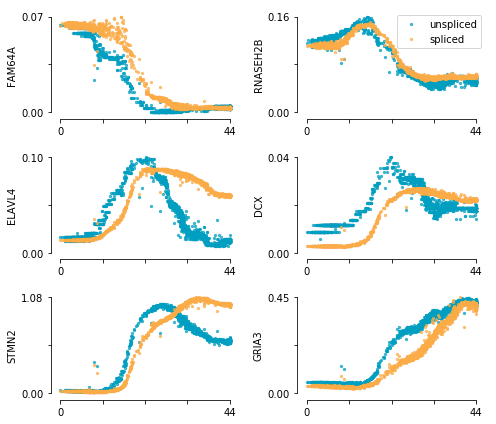

In [35]:
peek_shown = ["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]
plt.figure(None, (7,6.))
gs = plt.GridSpec(3,2)
for n, gene in enumerate(peek_shown):
    i = np.where(vlm.ra["Gene"] == gene)
    ax = plt.subplot(gs[n])
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Ux_sz[i, pc_obj.ixsort],
                alpha=0.7, c=np.array([0,159,193])/255, s=5, label="unspliced")
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Sx_sz[i, pc_obj.ixsort]*vlm.gammas[i],
                alpha=0.7, c=np.array([251, 172, 71])/255, s=5, label="spliced")
    m = 0 #np.minimum(np.min(vlm.Ux_sz[i,:]), np.min(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    M = np.maximum(np.max(vlm.Ux_sz[i,:]), np.max(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    plt.ylim(m - 0.07*(M-m), M + 0.07*(M-m))
    plt.ylabel(gene)
    plt.yticks([m,0.5*(m+M),M], [f"{m:.2f}", "", f"{M:.2f}"])
    p = np.min(pc_obj.arclength[pc_obj.ixsort])
    P = np.max(pc_obj.arclength[pc_obj.ixsort])
    plt.xticks(np.linspace(p,P,5), [f"{p:.0f}", "","","", f"{P:.0f}"])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_bounds(m, M)
    ax.spines['bottom'].set_bounds(p, P)
    if n == 1:
        plt.legend()
plt.tight_layout()